# Exploring Ensemble Forecasting with the Minimal Substorm Model

### First stab at a perturbed input ensemble
### Determining predictive skill...

In [1]:
import substorm_model as msm
import numpy as np
import datetime as dt

import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.omni as om

#plotting
import matplotlib as mpl
import matplotlib.dates as mpd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import spacepy.plot as splot
splot.style('default')
mpl.rcParams.update({'font.size': 15})
%matplotlib inline

/home/smorley/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/smorley/.local/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
np.random.seed(1337)

## Get solar wind data to drive ensemble
We'll be perturbing the solar wind driver, which in this case is calculated using a block resampling, so we first an appropriate set of data then add the errors for each ensemble member.

In [3]:
def fixOMNIVars(data):
    maglim = (-100, 100)
    vellim = (-1500, 1500)
    vlims = {'Bx_GSE': maglim,
     'By_GSE': maglim,
     'Bz_GSE': maglim,
     'By_GSM': maglim,
     'Bz_GSM': maglim,
     'Btot': (-150,150),
     'FlowSpeed': vellim,
     'Vx_GSE': vellim,
     'Vy_GSE': vellim,
     'Vz_GSE': vellim,
    }
    for key in vlims:
        ll = vlims[key][0]
        ul = vlims[key][1]
        data[key][data[key]>ul] = np.nan
        data[key][data[key]<ll] = np.nan
        not_nan = np.logical_not(np.isnan(data[key]))
        indices = np.arange(len(data[key]))
        data[key][...] = np.interp(indices, indices[not_nan], data[key][not_nan])
        
    return data

In [4]:
#Load IMF data and error series
data = dm.fromCDF('/mnt/projects/OMNI/OMNI_1min_2004.cdf')
data2 = dm.fromCDF('/mnt/projects/OMNI/OMNI_1min_2005.cdf')
for key in data:
    data[key] = dm.dmarray.concatenate(data[key], data2[key])
del data2

bzerr = dm.fromHDF5('/mnt/projects/SolarWindPerturb/MBB_Bz_GSM_errors.h5')
vxerr = dm.fromHDF5('/mnt/projects/SolarWindPerturb/MBB_Vx_GSE_errors.h5')

data = fixOMNIVars(data)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less


In [5]:
ticks = [dt.datetime(2005,1,28,19,18), dt.datetime(2005,1,31)]
inds = tb.tOverlapHalf(ticks, data['Epoch'])

n_runs = vxerr['errors'].shape[0]
bz = np.empty([n_runs, len(inds)])
vx = np.empty([n_runs, len(inds)])
theta = np.empty([n_runs, len(inds)])
btot = np.empty([n_runs, len(inds)])
bz[0,:] = data['Bz_GSM'][inds]
vx[0,:] = -1*data['Vx_GSE'][inds]
theta[0,:] = np.arctan2(data['By_GSM'][inds], data['Bz_GSM'][inds])
for run_num in range(1, n_runs):
    bz[run_num, :] = data['Bz_GSM'][inds] + bzerr['errors'][run_num, :len(inds)]
    vx[run_num, :] = -1*data['Vx_GSE'][inds] + vxerr['errors'][run_num, :len(inds)]
    dum = np.vstack([data['Bx_GSE'][inds], data['By_GSM'][inds], bz[run_num, :]])
    btot[run_num, :] = np.array([tb.hypot(n) for n in dum.T])
    theta[run_num, :] = np.arctan2(data['By_GSM'][inds], bz[run_num, :])
#put into SI
btot = btot*1e-9
vel = vx*1e3

times = data['Epoch'][inds]
epsilon = np.empty([n_runs, len(inds)])
for run_num in range(n_runs):
    epsilon[run_num, :] = (1/4e-7) * np.sin(theta[run_num, :]/2.0)**4 * vel[run_num, :] * btot[run_num, :]**2

In [6]:
#MSM setup
delta = dt.timedelta(seconds=60) #1 minute time resolution
minlen = dt.timedelta(hours=27) #set to minimum of 27 hours, to ensure that the whole interval is continuous
istart, iend = msm.findContiguousData(times, delta, minLength=minlen)

## Now we want to do an ensemble of forecasts

We want the results to be reproducible, but varying, so we set a seed for the sequence of restart values.

In [7]:
### For the perturbed parameter ensemble we have random restarts, here, we want to start on a substorm onset
#np.random.seed(7)
#seed_seq = np.random.randint(0, 1e6, n_runs)
istart, iend

([0], [3162])

In [8]:
results = []
for idx in range(n_runs):
    results.append(msm.msm(delta, times, epsilon[idx, :], istart, iend, 
                           tau0=2.69*3600, restartmode='onset'))

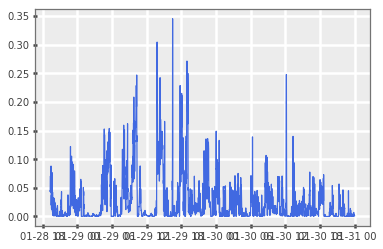

In [9]:
plt.plot(times, epsilon[1,:]*1e3)

In [10]:
t_arr = [np.array(r['t']).squeeze() for r in results]
n_valid = []
for arr in t_arr:
    n_valid.append(len(arr[arr>dt.datetime(2005,1,1)]))

print(np.mean(n_valid), np.median(n_valid), np.max(n_valid), np.min(n_valid))
print(np.argmax(n_valid))

(13.26, 7.0, 3162, 2)
0


In [11]:
windowticks = spt.tickrange(dt.datetime(2005,1,28,19,45), dt.datetime(2005,1,31), dt.timedelta(minutes=30))
wh = dt.timedelta(minutes=15)
numSS = []
binnedRuns = np.zeros([len(windowticks.UTC),500])
for idx_t, tt in enumerate(windowticks.UTC):
    SSinwin = []
    ttcomp = []
    for idx_a, arr in enumerate(t_arr):
        truthtable = np.logical_and(arr>tt-wh, arr<=tt+wh)
        binnedRuns[idx_t,idx_a] = truthtable.sum()
        SSinwin.append(np.any(truthtable))
    numSS.append(np.sum(SSinwin))

In [12]:
print(np.max(numSS))
print(np.argmax(numSS))

230
18


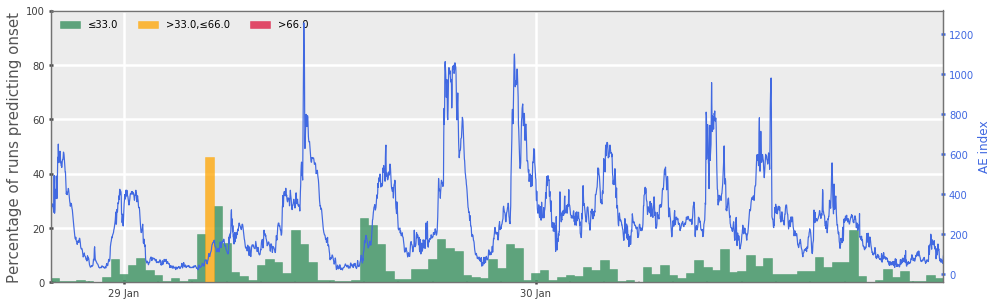

In [13]:
fig, ax = splot.set_target(None,figsize=(16,5))
ax2 = ax.twinx()
ax2.grid(False)
pltinds = tb.tOverlapHalf([windowticks.UTC[0], windowticks.UTC[-1]], data['Epoch'])
ax2.plot(data['Epoch'][pltinds], data['AE'][pltinds], 'royalblue')
ax2.tick_params(axis='y', colors='royalblue')
ax2.set_ylabel('AE index', color='royalblue')
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(33., 66.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=True)
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.set_ylim([0,100])
plt.savefig('MSM__PIensemble_forecast_289-29Jan2005_N=500_ALoverplot.png')

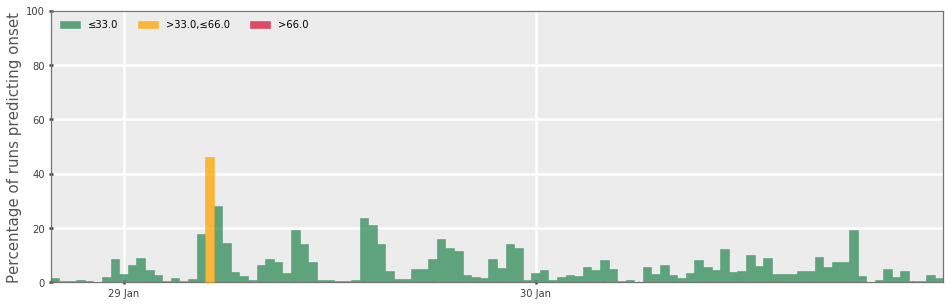

In [14]:
fig, ax = splot.set_target(None,figsize=(16,5))
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(33., 66.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=True)
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.set_ylim([0,100])
plt.savefig('MSM__PIensemble_forecast_289-29Jan2005_N=500.png')

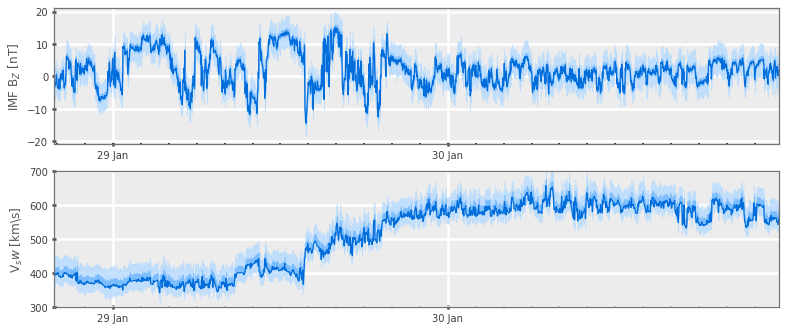

In [15]:
tlims = [windowticks.UTC[0], windowticks.UTC[-1]]
fig = plt.figure(figsize=(13,5.5))
ax = fig.add_subplot(211)
uq = np.empty(len(bz[0,:]))
lq = np.empty(len(bz[0,:]))
p025 = np.empty(len(bz[0,:]))
p975 = np.empty(len(bz[0,:]))
for n in range(len(bz[0,:])):
    p025[n], lq[n], uq[n], p975[n] = mlab.prctile(bz[:, n], (2.5, 25, 75, 97.5))
ax.fill_between(times, p025, p975, color=(0.7137,0.8588,1), alpha=0.8)
ax.fill_between(times, lq, uq, color=(0.4275,0.7137,1), alpha=0.8)
ax.plot(times, bz[0, :], color=(0,0.4275,0.8588))
splot.applySmartTimeTicks(ax, tlims)
ax.set_ylabel('IMF B$_Z$ [nT]')
ax.set_xlim(tlims)
ax.set_ylim([-21,21])
ax2 = fig.add_subplot(212)
for n in range(len(vx[0,:])):
    p025[n], lq[n], uq[n], p975[n] = mlab.prctile(vx[:, n], (2.5, 25, 75, 97.5))
ax2.fill_between(times, p025, p975, color=(0.7137,0.8588,1), alpha=0.8)
ax2.fill_between(times, lq, uq, color=(0.4275,0.7137,1), alpha=0.8)
ax2.plot(times, vx[0, :], color=(0,0.4275,0.8588))
ax2.set_ylabel('V$_sw$ [km\s]')
ax2.set_xlim(tlims)
ax2.set_ylim([300,700])
splot.applySmartTimeTicks(ax2, tlims)
plt.savefig('PIens_Jan2005_Vsw_Bz.png')

## Now let's get a sequence of observed substorms to test against...

In [29]:
t_JHobs = dm.dmarray(tb.loadpickle('/mnt/projects/MHDSubstorm/obs_onsets.pkl'))
sophie = dm.readJSONheadedASCII('/mnt/projects/Notebooks/SOPHIE_EPT90_Jan05.txt', convert=True)
####SOPHIE EPT90 list
#select only expansion phase onsets (phase 2)
expmask = sophie['Phase']==2
validmask = sophie['Flag']==0
sophiemask = np.bitwise_and(expmask,validmask)
t_sophie = sophie['DateTime'][sophiemask]
###B&Y
borov_data_raw = np.loadtxt('/mnt/projects/Notebooks/Borov_SML_Jan2005.txt')
t_borov = np.asarray([dt.datetime(2005,1,1)+dt.timedelta(days=fd-1) for fd in borov_data_raw[:,2]])
tBorovdiff = (t_borov[1:]-t_borov[:-1])
tauBorov = np.asarray([t.total_seconds() for t in tBorovdiff])/3600.

In [30]:
tJHdiff = (t_JHobs[1:]-t_JHobs[:-1])
tauJH = np.asarray([t.total_seconds() for t in tJHdiff])/3600.
tSOPHdiff = (t_sophie[1:]-t_sophie[:-1])
tauSOPH = np.asarray([t.total_seconds() for t in tSOPHdiff])/3600.
if 1==0:
    plt.figure(figsize=(12,9))
    pltbins = np.hstack([np.arange(0,12,0.5), np.arange(12.5,25.1,1)])
    #try plotting MSM tau histogram for each ensemble member using a very thin grey line, see what it looks like
    sum_n = np.zeros(pltbins.shape[0]-1)
    for ind in range(500):
        tmptau = t_arr[ind][1:]-t_arr[ind][:-1]
        plttau = np.asarray([t.total_seconds() for t in tmptau])/3600.
        if ind==0:
            n, bins, patches = plt.hist(plttau, bins=pltbins, normed=True, fill=False, 
                                        histtype='step', linewidth=2.0, color='silver', label='MSM - Individual runs')
        else:
            n, bins, patches = plt.hist(plttau, bins=pltbins, normed=True, fill=False, 
                                        histtype='step', linewidth=0.5, color='silver')
        sum_n += n
    mean_n = sum_n/500.
    ##mean MSM tau histo??
    #plt.plot(tb.bin_edges_to_center(pltbins), mean_n, drawstyle='steps', color='dimgrey', label='MSM mean')

    #or normed hist for full set of MSM runs??
    all_tau = np.array([])
    print(all_tau.shape)
    for ind in range(500):
        tmp_tau = t_arr[ind][1:]-t_arr[ind][:-1]
        tmp_tau_hr = np.asarray([t.total_seconds() for t in tmptau])/3600.
        all_tau = np.hstack([all_tau, tmp_tau_hr])

#plt.hist(all_tau, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='crimson', label='MSM - All runs (Mean={:0.2f}hr)'.format(all_tau.mean()))
#
#plt.hist(tauBorov, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='B&Y (Mean={:0.2f}hr)'.format(tauBorov.mean()), color='royalblue')
#plt.xlim([0,25])
#plt.ylim([0,0.4])
#plt.xlabel(r'$\tau$ [hours]', fontsize=16)
#plt.vlines(tauBorov.mean(),0,1, linestyles='dashed', color='royalblue')
#plt.legend()
#plt.savefig('PIens_intersubstorm_intervals_BandY.png')

In [31]:
#fig = plt.figure(figsize=(12,9))
#ax = fig.add_subplot(111)
#plot taus
#n, bins, patches = ax.hist(tauSOPH, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='Observed SOPHIE (Mean={:0.2f}hr)'.format(tauSOPH.mean()), color='violet')

####Borovsky SML list
#ax.hist(tauBorov, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='royalblue', label='Borovsky SML (Mean={:0.2f}hr)'.format(all_tau.mean()))
#ax.hist(all_tau, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='crimson', label='MSM - All runs (Mean={:0.2f}hr)'.format(all_tau.mean()))
#ax.hist(tauJH, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='Observed JH (Mean={:0.2f}hr)'.format(tauJH.mean()), color='seagreen')
#ax.legend()
#plt.savefig('PIens_compare_observed_intersubstorm.png')

In [37]:
SSyesno = []
SSsource = 'B&Y' # ('Obs','SOPHIE','B&Y')
for tt in windowticks.UTC:
    if SSsource.upper()=='OBS':
        SSyesno.append(np.any(np.logical_and(t_JHobs>tt-wh, t_JHobs<=tt+wh))) # JH list
    elif SSsource.upper()=='SOPHIE':
        SSyesno.append(np.any(np.logical_and(t_sophie>tt-wh, t_sophie<=tt+wh))) #SOPHIE EPT90
    elif SSsource.upper()=='B&Y':
        SSyesno.append(np.any(np.logical_and(t_borov>tt-wh, t_borov<=tt+wh))) #Borovsky SML
    else:
        raise Exception
SSyesno = dm.dmarray(SSyesno)
print('Using {} list, which has {} substorm onsets'.format(SSsource, SSyesno.sum()))
print(np.where(t_borov))

Using B&Y list, which has 9 substorm onsets
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123]),)


In [38]:
from sklearn.metrics import roc_curve
from verify import Contingency2x2
fpr, tpr, thresholds = roc_curve(SSyesno, np.asarray(numSS)/5.)
thresholds = np.asarray(thresholds)
EnsembleThresh = thresholds[np.argmax(tpr-fpr)]
FPRAtThresh = fpr[thresholds==EnsembleThresh]

Number of runs with +ve skill: 0
Number of runs with 0/-ve skill: 0


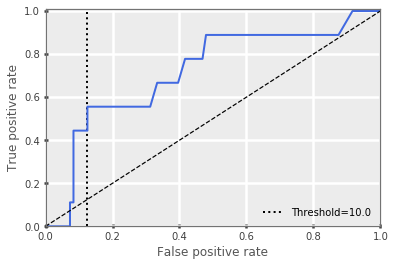

In [39]:
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.vlines(FPRAtThresh, 0, 1, linestyles=':', lw=2, label='Threshold={}'.format(EnsembleThresh))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1.01])
    
####
#plt.title('ROC curve - MSM & {}'.format(SSsource))
sourcetitle = SSsource.replace('&','and') if '&' in SSsource else SSsource

####
#add TPR/FPR for sample runs
goodcount = 0
badcount = 0
if False: #for rn in np.random.randint(0,499,100):#[1, 73, 101, 173, 201, 273, 301, 373]:
    ct = Contingency2x2.fromBoolean(binnedRuns[:,rn], SSyesno)
    #ct.summary(True)
    tpr, tpr_err = ct.POD(ci=True)
    fpr, fpr_err = ct.POFD(ci=True)
    if tpr-fpr>0.25:
        goodcount += 1
        plt.errorbar(fpr, tpr, xerr=fpr_err, yerr=tpr_err, fmt='o', color='seagreen', ecolor='g', capsize=2, capthick=2)
    if tpr-fpr<=0:
        badcount+=1
        plt.errorbar(fpr, tpr, xerr=fpr_err, yerr=tpr_err, fmt='o', color='r', ecolor='r', capsize=2, capthick=2)
print('Number of runs with +ve skill: {}'.format(goodcount))
print('Number of runs with 0/-ve skill: {}'.format(badcount))
plt.savefig('MSM_PIensemble_{}_ROC.png'.format(sourcetitle))

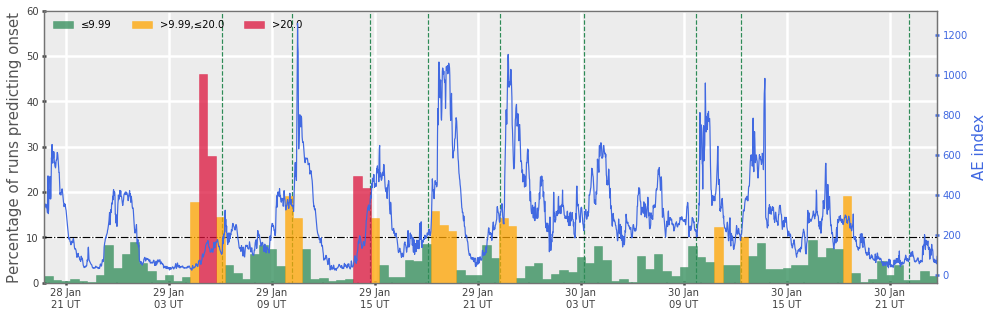

In [46]:
fig, ax = splot.set_target(None,figsize=(16,5))
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(EnsembleThresh-0.01, EnsembleThresh*2.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=True)
for ots in t_borov:
    plt.vlines(ots, -5000,2000, linestyles='dashed', color='seagreen')
ax.set_ylim([0,60])
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.hlines(EnsembleThresh, windowticks.UTC[0], windowticks.UTC[-1], linestyles='-.')
ax2 = ax.twinx()
ax2.grid(False)
pltinds = tb.tOverlapHalf([windowticks.UTC[0], windowticks.UTC[-1]], data['Epoch'])
ax2.plot(data['Epoch'][pltinds], data['AE'][pltinds], 'royalblue')
ax2.tick_params(axis='y', colors='royalblue')
ax2.set_ylabel('AE index', color='royalblue', fontsize=15)
ax2.xaxis.set_major_formatter(mpd.DateFormatter('%d %b\n%H UT'))
plt.savefig('MSM_PIensemble_forecast_28-29Jan2005_N=500_thresh.png')
##TODO: Add observed onsets to plot. Make sure list has manually identified onsets from Morley paper

### Now we choose the threshold that gave us the largest positive deviation and generate a contingency table for analysis

In [42]:
fracPredict = 100*np.asarray(numSS)/float(n_runs)
PredAtThresh = fracPredict>=EnsembleThresh

ctable = Contingency2x2.fromBoolean(PredAtThresh, SSyesno)
print(ctable)
print('\n')
ctable.summary(verbose=True, ci='bootstrap')

[[ 5 12]
 [ 4 84]]


Contingency2x2([
  [     5,    12],
  [     4,    84])

Summary Statistics
Bias: 1.8889 [1.0000, 4.2521]
FAR: 0.7059 [0.4736, 0.9201]
PC: 0.8476 [0.7810, 0.9143]
POFD: 0.1250 [0.0612, 0.1959]
POD: 0.5556 [0.2000, 0.9000]
ThreatScore: 0.2381 [0.0588, 0.4286]
OddsRatio: 8.7500

Skill Scores
HeidkeScore: 0.3069 [0.0415, 0.5544]
PeirceScore: 0.4306 [0.0660, 0.7743]
EquitableThreatScore: 0.1813 [0.0212, 0.3835]
YuleQ: 0.7949

Classification Quality Metrics
MajorityClassFraction: 0.9143
MatthewsCC: 0.3272


## Notable results
- The MSM is overpredicting substorms relative to this list of observed onsets
- The low threshold increases the bias
- The "best" prediction (ratio of True Pos to False Pos) gives a high rate of false positives
- The predictive skill is higher than th SWMF runs...
- Proportion correct is lower than the majority class fraction (PC for case where all predictions are majority type)

## Let's just plot some of the substorm activity for the month out...

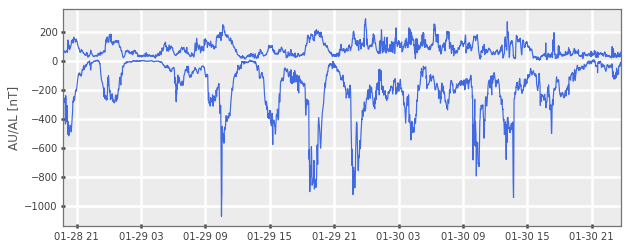

In [43]:
#tlims = [dt.datetime(2005,1,28,19), dt.datetime(2005,1,31)]
#pltinds = tb.tOverlapHalf(tlims, times)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(data['Epoch'][pltinds], data['AL'][pltinds], 'royalblue')
ax.plot(data['Epoch'][pltinds], data['AU'][pltinds], 'royalblue')
ax.set_xlim(tlims)
ax.set_ylabel('AU/AL [nT]')
plt.savefig('Jan2005zoom_AU_AL_activity.png')

In [44]:
###Find MSM run with highest skill
score = []
tables = []
for pred_ind in binnedRuns.T:
    ctable_ind = Contingency2x2.fromBoolean(pred_ind, SSyesno)
    tables.append(ctable_ind)
    score.append(ctable_ind.peirce())
score = np.asarray(score)
best_indi = np.argmax(score)
print('{} runs have same max score'.format((score==score.max()).sum()))
print(np.where(score==score.max()))
print('Using run # {}'.format(best_indi))
tables[np.argmax(score)].summary(verbose=True, ci='bootstrap')

1 runs have same max score
(array([233]),)
Using run # 233
Contingency2x2([
  [     4,     5],
  [     5,    91])

Summary Statistics
Bias: 1.0000 [0.4444, 2.2500]
FAR: 0.5556 [0.2000, 0.9000]
PC: 0.9048 [0.8476, 0.9619]
POFD: 0.0521 [0.0105, 0.1010]
POD: 0.4444 [0.1000, 0.8000]
ThreatScore: 0.2857 [0.0588, 0.5455]
OddsRatio: 14.5600

Skill Scores
HeidkeScore: 0.3924 [0.0377, 0.6801]
PeirceScore: 0.3924 [0.0367, 0.7600]
EquitableThreatScore: 0.2441 [0.0192, 0.5153]
YuleQ: 0.8715

Classification Quality Metrics
MajorityClassFraction: 0.9143
MatthewsCC: 0.3924


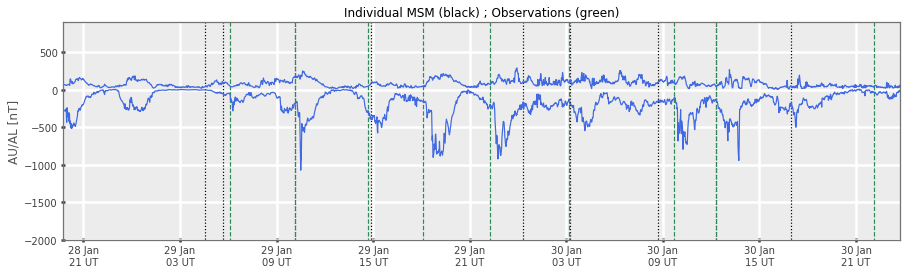

In [45]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.plot(data['Epoch'][pltinds], data['AL'][pltinds], 'royalblue')
ax.plot(data['Epoch'][pltinds], data['AU'][pltinds], 'royalblue')
ax.set_xlim(tlims)
##add onsets from a random MSM run
for ots in t_arr[best_indi]:
    plt.vlines(ots, -5000,2000, linestyles='dotted', color='k')
#and add onsets from B&Y
for ots in t_borov:
    plt.vlines(ots, -5000,2000, linestyles='dashed', color='seagreen')
ax.set_ylim([-2000, 900])
#ax.set_xlim([dt.datetime(2005,1,28), dt.datetime(2005,1,30)])
ax.set_ylabel('AU/AL [nT]')
ax.set_title('Individual MSM (black) ; Observations (green)')
ax.xaxis.set_major_formatter(mpd.DateFormatter('%d %b\n%H UT'))
plt.savefig('MSM_PI_bestrun_vs_ObsJH_Jan28-30.png')